In [1]:
import os
import sys
import pathlib
import math
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline 

import numpy as np
import pandas as pd

import statistics
from scipy.stats import norm, false_discovery_control, zscore

from IPython.display import clear_output

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
columns = ['BR_mean', 'AL_mean', 'tidal_area', 'breath_duration', 'peak_respiratory_flow']
features = ['BR_mean', 'tidal_area', 'breath_duration', 'peak_respiratory_flow']
patterns = ['tidal_area', 'breath_duration', 'peak_respiratory_flow']

In [4]:
long_ids = os.listdir("E:/UG4data/NHS_HAR_r30s")
df_score = pd.read_csv('results/NHS/df_scores.csv', parse_dates=["date"])
df_score = df_score[df_score.id != "PRB109"]
ids = df_score.id.unique()
ids

array(['PRB001', 'PRB003', 'PRB005', 'PRB006', 'PRB007', 'PRB102',
       'PRB103', 'PRB104', 'PRB105', 'PRB107', 'PRB108', 'PRB201',
       'PRB202', 'PRB203', 'PRX018', 'PRX900'], dtype=object)

## Process for TMLE

In [9]:
df_score = pd.read_csv('results/NHS/df_scores.csv', parse_dates=["date"])
df_score['date'] = df_score.date.dt.date
df_score = df_score.drop('CAT_7', axis=1)
df_score = df_score[df_score.id != "PRB109"]
df_score

,date,average_sleep_hrs,sleep_efficiency_night,sleep_percentage_night,short_awakenings,position_changes,id,score
0,2021-07-23,1.850000,0.776316,1.027027,0.108108,0.000000,PRB001,4.350793
1,2021-07-24,2.291667,0.618454,1.458182,0.061818,0.097561,PRB001,4.183270
2,2021-07-25,2.125000,0.688034,0.917647,0.043137,0.082569,PRB001,4.292348
3,2021-07-26,6.316667,0.775213,1.085752,0.026385,0.006154,PRB001,3.150981
4,2021-07-29,1.891667,0.555891,1.458150,0.074890,0.071429,PRB001,4.311582
...,...,...,...,...,...,...,...,...
700,2021-11-15,5.433333,0.648760,0.742331,0.079755,0.078358,PRX900,3.470033
701,2021-11-16,4.375000,0.842697,1.186667,0.003810,0.080000,PRX900,3.610773
702,2021-11-17,6.591667,0.709677,0.352718,0.046776,0.012285,PRX900,3.214778
703,2021-11-18,8.083333,0.790049,0.849485,0.032990,0.021563,PRX900,2.719429


In [7]:
df_agg = pd.DataFrame()
for id in ids:
    df = pd.read_csv(f'results/NHS/SleepAwake/{id}_semi.csv', parse_dates=["timestamp"])
    df_br = pd.read_csv(f"E:/UG4data/NHS_breathing/{id}.csv", parse_dates=["startTimestamp"])
    df_br = df_br.rename({"area": "tidal_area", "duration": "breath_duration", "peakRespiratoryFlow": "peak_respiratory_flow"}, axis=1)
    df_br = df_br.drop("extremas", axis=1).dropna()
    z_scores = df_br[patterns].apply(zscore)
    df_br = df_br[(z_scores.abs() <= 3).all(axis=1)]
    df = pd.merge(df, df_br,  how='left', left_on="timestamp", right_on="startTimestamp")
    df['date'] = df.timestamp.dt.date
    gb = df[['date'] + columns].groupby('date').mean()
    # print(gb.columns)
    gb['sleep_percentage'] = df[['date', 'isSleep']].groupby('date').apply(lambda x: len(x[x.isSleep == 1]) / len(x), include_groups=False)
    gb['id'] = id
#     for c in columns:
#         gb[c + '_sleep'] = df[df.isSleep == 1][['date', c]].groupby('date').mean()
#     for c in columns:
#         gb[c + '_awake'] = df[df.isSleep == 0][['date', c]].groupby('date').mean()
    df_agg = pd.concat([df_agg, gb])

df_agg = df_agg.reset_index()
df_agg

,date,BR_mean,AL_mean,tidal_area,breath_duration,peak_respiratory_flow,sleep_percentage,id
0,2021-07-07,20.586668,0.096891,0.472344,1.537046,0.438905,0.028571,PRB001
1,2021-07-08,19.922117,0.054665,0.572304,1.728756,0.538989,0.225989,PRB001
2,2021-07-09,22.999217,0.114246,0.660946,1.360339,0.771665,0.107143,PRB001
3,2021-07-10,22.331551,0.128184,0.608458,1.403815,0.715631,0.018182,PRB001
4,2021-07-13,20.945286,0.136648,0.706845,1.666938,0.819048,0.192308,PRB001
...,...,...,...,...,...,...,...,...
938,2021-11-15,18.586116,0.072663,0.543955,1.704951,0.561570,0.416347,PRX900
939,2021-11-16,18.189666,0.028765,0.480312,1.639102,0.532854,0.842697,PRX900
940,2021-11-17,18.394558,0.062108,0.552916,1.727893,0.567467,0.561391,PRX900
941,2021-11-18,18.493321,0.072445,0.565795,1.695816,0.590896,0.569249,PRX900


In [13]:
df_merged = pd.merge(df_score, df_agg,  how='left', left_on=['id', 'date'], right_on=['id', 'date'])
# df_merged = pd.merge(df_merged, df_CAT[["id","date","Overall_score"]], how='left', left_on=['id', 'date'], right_on=['id', 'date'])
df_merged

,date,average_sleep_hrs,sleep_efficiency_night,sleep_percentage_night,short_awakenings,position_changes,id,score,BR_mean,AL_mean,tidal_area,breath_duration,peak_respiratory_flow,sleep_percentage
0,2021-07-23,1.850000,0.776316,1.027027,0.108108,0.000000,PRB001,4.350793,19.684255,0.082692,0.418775,1.512544,0.405204,0.179757
1,2021-07-24,2.291667,0.618454,1.458182,0.061818,0.097561,PRB001,4.183270,18.674866,0.048100,0.582224,1.808006,0.489480,0.440000
2,2021-07-25,2.125000,0.688034,0.917647,0.043137,0.082569,PRB001,4.292348,19.608648,0.058419,0.459591,1.815710,0.402304,0.344595
3,2021-07-26,6.316667,0.775213,1.085752,0.026385,0.006154,PRB001,3.150981,17.860778,0.026302,0.347779,1.646621,0.372923,0.679821
4,2021-07-29,1.891667,0.555891,1.458150,0.074890,0.071429,PRB001,4.311582,19.956807,0.075925,0.442386,1.455139,0.492768,0.212946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,2021-11-15,5.433333,0.648760,0.742331,0.079755,0.078358,PRX900,3.470033,18.586116,0.072663,0.543955,1.704951,0.561570,0.416347
689,2021-11-16,4.375000,0.842697,1.186667,0.003810,0.080000,PRX900,3.610773,18.189666,0.028765,0.480312,1.639102,0.532854,0.842697
690,2021-11-17,6.591667,0.709677,0.352718,0.046776,0.012285,PRX900,3.214778,18.394558,0.062108,0.552916,1.727893,0.567467,0.561391
691,2021-11-18,8.083333,0.790049,0.849485,0.032990,0.021563,PRX900,2.719429,18.493321,0.072445,0.565795,1.695816,0.590896,0.569249


In [10]:
df_merged.columns

Index(['date', 'average_sleep_hrs', 'sleep_efficiency_night',
       'sleep_percentage_night', 'short_awakenings', 'position_changes', 'id',
       'score', 'BR_mean', 'AL_mean', 'tidal_area', 'breath_duration',
       'peak_respiratory_flow', 'sleep_percentage', 'Overall_score'],
      dtype='object')

In [14]:
df_merged = df_merged.dropna()
df_merged.to_csv('results/NHS/df_agg.csv')

## Sleep-wake percentage

In [46]:
df_sleep_wake = pd.DataFrame()
for id in ids:
    df = pd.read_csv(f'results/NHS/SleepAwake/{id}_semi.csv', parse_dates=["timestamp"])
    df_br = pd.read_csv(f"E:/UG4data/NHS_breathing/{id}.csv", parse_dates=["startTimestamp"])
    df_br = df_br.rename({"area": "tidal_area", "duration": "breath_duration", "peakRespiratoryFlow": "peak_respiratory_flow"}, axis=1)
    df_br = df_br.drop(["extremas"], axis=1).dropna()
    z_scores = df_br[patterns].apply(zscore)
    df_br = df_br[(z_scores.abs() <= 3).all(axis=1)]
    df = pd.merge(df, df_br,  how='left', left_on="timestamp", right_on="startTimestamp")
    df['date'] = df.timestamp.dt.date
    gb = df[['date'] + columns].groupby('date').mean()
    # print(gb.columns)
    gb['sleep_percentage'] = df[['date', 'isSleep']].groupby('date').apply(lambda x: len(x[x.isSleep == 1]) / len(x), include_groups=False)
    gb['id'] = id
    for c in columns:
        gb[c + '_sleep'] = df[df.isSleep == 1][['date', c]].groupby('date').mean()
    for c in columns:
        gb[c + '_awake'] = df[df.isSleep == 0][['date', c]].groupby('date').mean()
    df_sleep_wake = pd.concat([df_sleep_wake, gb])

df_sleep_wake = df_sleep_wake.reset_index()
df_sleep_wake = df_sleep_wake[df_sleep_wake.id != "PRB109"]
df_sleep_wake

,date,BR_mean,AL_mean,tidal_area,breath_duration,peak_respiratory_flow,sleep_percentage,id,BR_mean_sleep,AL_mean_sleep,tidal_area_sleep,breath_duration_sleep,peak_respiratory_flow_sleep,BR_mean_awake,AL_mean_awake,tidal_area_awake,breath_duration_awake,peak_respiratory_flow_awake
0,2021-07-07,20.586668,0.096891,0.472344,1.537046,0.438905,0.028571,PRB001,16.006209,0.116926,0.675269,1.770567,0.381790,20.721388,0.096302,0.467766,1.531779,0.440193
1,2021-07-08,19.922117,0.054665,0.572304,1.728756,0.538989,0.225989,PRB001,18.372152,0.027806,0.434720,2.119594,0.450558,20.374661,0.062507,0.591179,1.675139,0.551120
2,2021-07-09,22.999217,0.114246,0.660946,1.360339,0.771665,0.107143,PRB001,23.921267,0.104843,1.019873,1.327780,0.931969,22.888571,0.115375,0.617875,1.364247,0.752428
3,2021-07-10,22.331551,0.128184,0.608458,1.403815,0.715631,0.018182,PRB001,21.320918,0.130288,0.512842,1.490000,0.624666,22.350267,0.128145,0.610297,1.402158,0.717381
4,2021-07-13,20.945286,0.136648,0.706845,1.666938,0.819048,0.192308,PRB001,20.144386,0.146875,0.740031,2.524910,0.729546,21.135976,0.134213,0.698944,1.462659,0.840358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2021-11-15,18.586116,0.072663,0.543955,1.704951,0.561570,0.416347,PRX900,17.764075,0.040953,0.478532,1.698493,0.510144,19.172518,0.095283,0.596241,1.710112,0.602669
939,2021-11-16,18.189666,0.028765,0.480312,1.639102,0.532854,0.842697,PRX900,17.940137,0.024988,0.478808,1.657009,0.530296,19.526433,0.049001,0.488694,1.539278,0.547110
940,2021-11-17,18.394558,0.062108,0.552916,1.727893,0.567467,0.561391,PRX900,17.388143,0.034718,0.525530,1.734908,0.549076,19.682705,0.097166,0.594310,1.717290,0.595265
941,2021-11-18,18.493321,0.072445,0.565795,1.695816,0.590896,0.569249,PRX900,17.713813,0.035824,0.553461,1.695046,0.589544,19.523462,0.120841,0.586514,1.697111,0.593167


In [47]:
df_sleep_wake_agg = df_sleep_wake.drop('date', axis=1).groupby('id').mean()
df_sleep_wake_agg

,BR_mean,AL_mean,tidal_area,breath_duration,peak_respiratory_flow,sleep_percentage,BR_mean_sleep,AL_mean_sleep,tidal_area_sleep,breath_duration_sleep,peak_respiratory_flow_sleep,BR_mean_awake,AL_mean_awake,tidal_area_awake,breath_duration_awake,peak_respiratory_flow_awake
id,,,,,,,,,,,,,,,,
PRB001,20.867901,0.078815,0.682770,1.830596,0.587994,0.293361,19.709788,0.055429,0.576937,1.776120,0.520070,21.669988,0.090902,0.749405,1.811090,0.633248
PRB003,20.398521,0.063814,0.470680,1.635283,0.486067,0.455080,19.383315,0.040474,0.416990,1.666393,0.422511,21.206415,0.090415,0.543187,1.609403,0.567415
PRB005,18.460058,0.078074,0.383046,1.668915,0.383656,0.270043,16.093315,0.048018,0.408351,1.902505,0.372772,19.627860,0.092384,0.384629,1.578019,0.397117
PRB006,19.201577,0.050106,0.434720,1.618958,0.433305,0.533299,17.701845,0.032045,0.451643,1.715512,0.431180,20.999547,0.070916,0.421678,1.521434,0.439124
PRB007,21.771309,0.069554,0.323023,1.422834,0.367941,0.550668,21.291224,0.053634,0.302902,1.444262,0.341345,22.719860,0.096895,0.365463,1.377522,0.419002
PRB102,19.635371,0.039418,0.236021,1.580440,0.235476,0.259388,18.893915,0.027137,0.248042,1.628347,0.235040,19.888449,0.043935,0.233475,1.565886,0.236371
PRB103,22.048614,0.047932,0.427435,1.408573,0.508271,0.296959,19.386663,0.023081,0.397368,1.537259,0.455270,23.227127,0.058210,0.433649,1.351876,0.524324
PRB104,19.066261,0.078965,0.403220,1.637568,0.429223,0.590337,17.684616,0.055230,0.370300,1.720000,0.378364,21.123050,0.113575,0.445223,1.529749,0.494336
PRB105,19.551490,0.067951,0.510079,1.635803,0.548289,0.489044,17.824186,0.039158,0.444867,1.738795,0.459821,21.373589,0.101078,0.576011,1.531519,0.637270


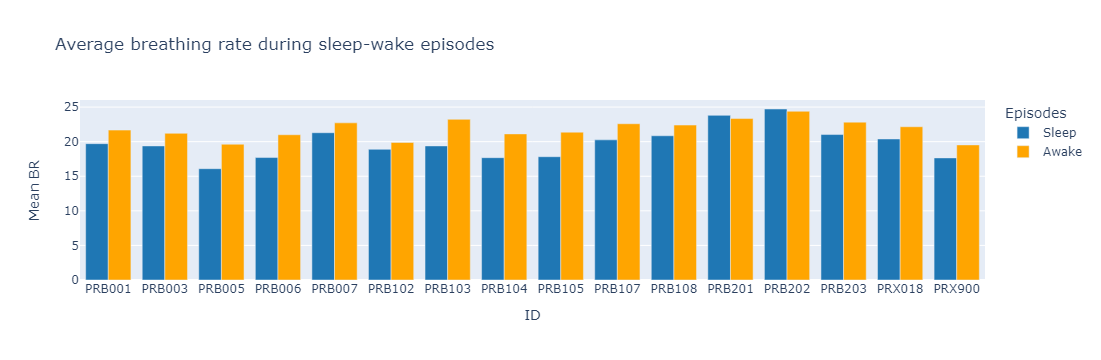

In [55]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_sleep_wake_agg.index,
    y=df_sleep_wake_agg.BR_mean_sleep,
    name='Sleep',
    marker_color='#1f77b4'
))

fig.add_trace(go.Bar(
    x=df_sleep_wake_agg.index,
    y=df_sleep_wake_agg.BR_mean_awake,
    name='Awake',
    marker_color='orange'
))

fig.update_layout(
    barmode='group',
    title="Average breathing rate during sleep-wake episodes",
    xaxis_title="ID",
    yaxis_title="Mean BR",
    legend_title="Episodes"
)

fig.show()

## CAT

In [5]:
df_CAT = pd.read_csv('results/NHS/df_CAT.csv', parse_dates=["timestamp"])
df_CAT["date"] = df_CAT.timestamp.dt.date
df_CAT

,timestamp,Cough,Phlegm,Chest_tightness,Breathlessness,Activities,Confidence,Sleeplessness,Energy,Overall_score,id,date
0,2021-08-19 17:42:05,1,1,1,1,0,0,0,1,5,PRB003,2021-08-19
1,2021-08-20 21:06:33,1,1,1,1,0,0,5,3,12,PRB003,2021-08-20
2,2021-08-21 20:43:33,1,1,0,1,0,0,0,1,4,PRB003,2021-08-21
3,2021-08-22 22:38:41,2,2,0,2,1,0,0,2,9,PRB003,2021-08-22
4,2021-08-23 22:18:53,1,1,1,1,1,1,0,1,7,PRB003,2021-08-23
...,...,...,...,...,...,...,...,...,...,...,...,...
501,2021-11-11 21:19:36,2,2,2,2,1,1,2,2,14,PRX900,2021-11-11
502,2021-11-13 17:26:50,1,1,1,2,1,0,3,2,11,PRX900,2021-11-13
503,2021-11-15 04:44:36,2,1,2,2,2,1,3,2,15,PRX900,2021-11-15
504,2021-11-18 17:23:08,2,2,2,1,1,2,3,2,15,PRX900,2021-11-18


In [21]:
def CAT_colormap(data, c, n=8, k=5, title='', savefig=''):
    # Using a blue to red colormap
    colormap = plt.get_cmap('coolwarm')
    colors = [colormap(i / (n - 1)) for i in range(n)]
    
    # Plotting the stacked barh chart
    fig, ax = plt.subplots(figsize=(6, 8), dpi=80)
    bottoms = np.zeros(len(ids))
    
    # plt.barh(ids, df_score.groupby(['id']).size(), color='lightgrey', label=f'missing CAT', alpha=0.5)
    
    for i in range(n):
        df = data[(data[c]>=i*k) & (data[c]<i*k+k)]
        num = [len(df[df.id==id]) for id in ids]
        if k == 1:
            plt.barh(ids, num, left=bottoms, color=colors[i], label=i)
        else:
            plt.barh(ids, num, left=bottoms, color=colors[i], label=f'{i*k}-{i*k+k-1}')
        bottoms += num
    
    ax.set_xlabel('days of CAT recordings')
    ax.set_title(title)
    plt.legend(title=f'CAT score (0-{n-1})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # if savefig:
    #     plt.savefig(f'results/NHS/graphs/data/{savefig}.png')
    
    plt.show()

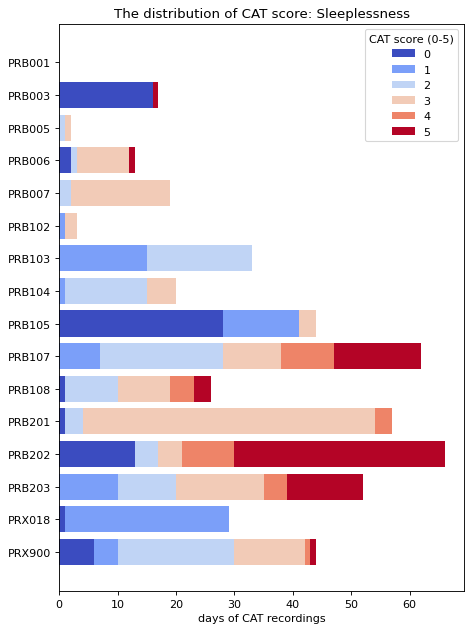

In [22]:
CAT_colormap(df_CAT, 'Sleeplessness', 6, 1, 'The distribution of CAT score: Sleeplessness')

In [30]:
df_CAT[['id', 'Sleeplessness']].groupby('id').mean()

,Sleeplessness
id,
PRB003,0.294118
PRB004,3.500000
PRB005,2.500000
PRB006,2.615385
PRB007,2.894737
PRB102,2.333333
PRB103,1.545455
PRB104,2.200000
PRB105,0.500000


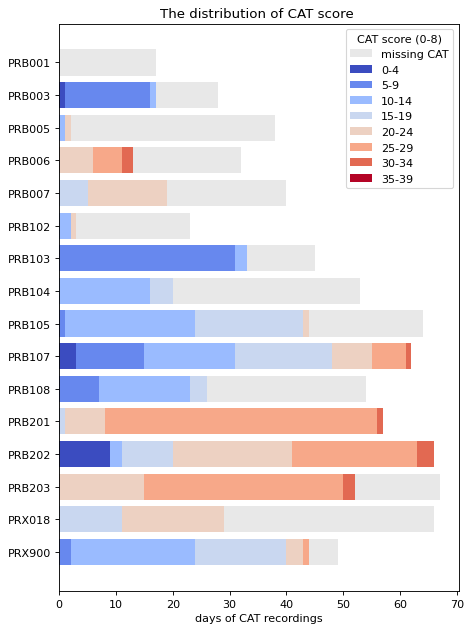

In [29]:
CAT_colormap(df_CAT, 'Overall_score')

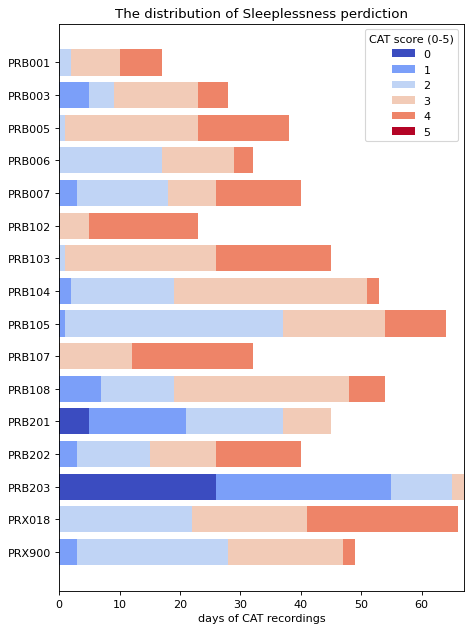

In [23]:
CAT_colormap(df_score, 'score', 6, 1, 'The distribution of Sleeplessness perdiction')

In [50]:
def plot_tmle(file, title):
    df = pd.read_csv(f"results/NHS/TMLE/{file}") 
    df.columns=["subject", "est", "se"]
    
    plt.figure(figsize=(4, 6))
    # df = df.drop(df[df.subject == "PRB109"].index)
    # df = df.drop(df[df.subject == "PRX900"].index)
    if title.endswith("day"):
        return
    elif title.endswith("sleep"):
        plt.errorbar(df['est'], df['subject'], xerr=df['se'], linestyle='None', fmt='o')
    elif title.endswith("awake"):
        plt.errorbar(df['est'], df['subject'], xerr=df['se'], linestyle='None', fmt='o', color='darkorange')
    else:
        plt.errorbar(df['est'], df['subject'], xerr=df['se'], linestyle='None', fmt='o', color='green')
    plt.axvline(x=0, color='red', linestyle='--', c='grey')
    plt.gca().invert_yaxis()
    plt.xlabel("sleeplessness score")
    plt.ylabel("subject ids")
    plt.title(f"TMLE: Effect of '{title[5:]}' on 'sleeplessness score'")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'results/NHS/graphs/TMLE/{file}.png', bbox_inches = "tight")

In [20]:
id_num = pd.DataFrame(columns=["id", "sleep", "awake", "days"])
scores = pd.read_csv("results/NHS/df_agg.csv")
for f in os.listdir('results/NHS/SleepAwake/'):
    df = pd.read_csv('results/NHS/SleepAwake/' + f)
    id = f[:6]
    if len(scores[scores.id == id]) != 0:
        id_num.loc[len(id_num)] = {"id": id, 
                                   "sleep": len(df[df.isSleep == 1]), 
                                   "awake": len(df[df.isSleep == 0]), 
                                   "days": len(scores[scores.id == id])}
id_num = id_num.set_index("id")
id_num

,sleep,awake,days
id,,,
PRB001,11199,20272,17
PRB003,28890,30546,28
PRB005,20048,43437,38
PRB006,26604,24007,32
PRB007,31599,19745,40
PRB102,20510,58094,23
PRB103,24660,54183,45
PRB104,42391,28470,53
PRB105,50777,48093,63


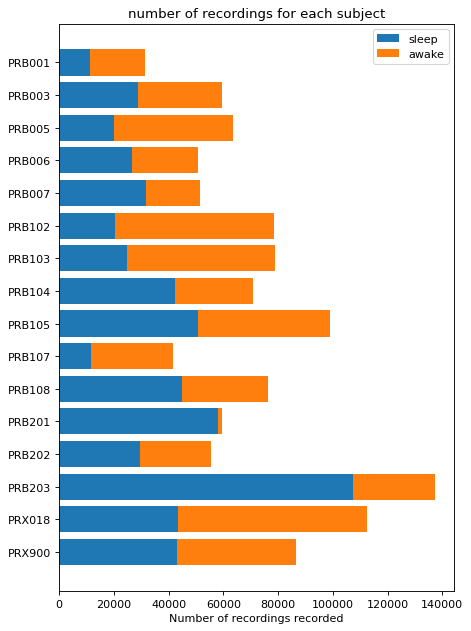

In [23]:
plt.figure(figsize=(6, 8), dpi=80)
plt.barh(id_num.index, id_num.sleep, label="sleep")
plt.barh(id_num.index, id_num.awake, left=id_num.sleep, label="awake")
plt.gca().invert_yaxis()
plt.xlabel("Number of recordings recorded")
plt.title("number of recordings for each subject")
plt.legend()
plt.tight_layout()
plt.savefig('results/NHS/graphs/data/num_sleepwake.png')
plt.show()

Average days:  41.41


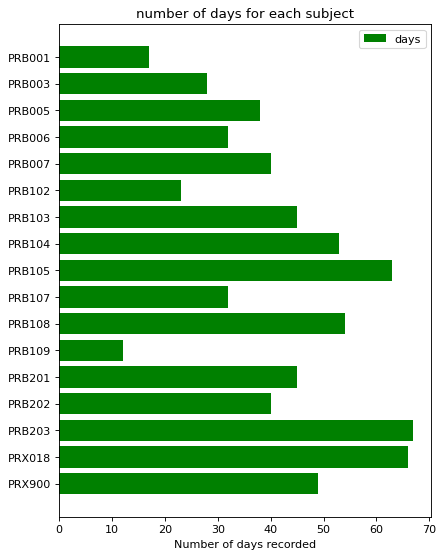

In [52]:
plt.figure(figsize=(6, 8), dpi=80)
plt.barh(id_num.index, id_num.days, label="days", color='green')
plt.gca().invert_yaxis()
plt.xlabel("Number of days recorded")
plt.title("number of days for each subject")
plt.legend()
plt.plot()
print("Average days: ", round(id_num.days.mean(), 2))

In [6]:
df = df_CAT.copy()
# Function to determine score range
def get_score_range(score):
    if score == 40:
        return 40
    for range_start in range(0, 40, 5):
        if range_start <= score < range_start + 5:
            # return f'{range_start}-{range_start + 4}'
            return range_start
    return 'Unknown'

# Apply function to create a new 'Score_Range' column
df['Score_Range'] = df['Overall_score'].apply(get_score_range)
df

,timestamp,Cough,Phlegm,Chest_tightness,Breathlessness,Activities,Confidence,Sleeplessness,Energy,Overall_score,id,date,Score_Range
0,2021-08-19 17:42:05,1,1,1,1,0,0,0,1,5,PRB003,2021-08-19,5
1,2021-08-20 21:06:33,1,1,1,1,0,0,5,3,12,PRB003,2021-08-20,10
2,2021-08-21 20:43:33,1,1,0,1,0,0,0,1,4,PRB003,2021-08-21,0
3,2021-08-22 22:38:41,2,2,0,2,1,0,0,2,9,PRB003,2021-08-22,5
4,2021-08-23 22:18:53,1,1,1,1,1,1,0,1,7,PRB003,2021-08-23,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,2021-11-11 21:19:36,2,2,2,2,1,1,2,2,14,PRX900,2021-11-11,10
502,2021-11-13 17:26:50,1,1,1,2,1,0,3,2,11,PRX900,2021-11-13,10
503,2021-11-15 04:44:36,2,1,2,2,2,1,3,2,15,PRX900,2021-11-15,15
504,2021-11-18 17:23:08,2,2,2,1,1,2,3,2,15,PRX900,2021-11-18,15


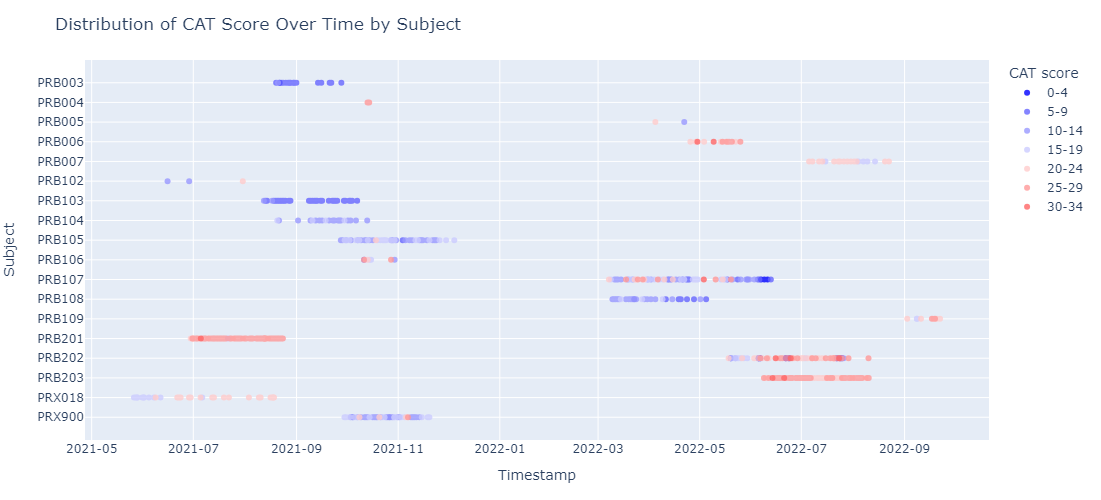

In [24]:
# Define color scale for each score range
color_scale = {
    0: '#0000FF',
    5: '#6666FF',
    10: '#9999FF',
    15: '#CCCCFF',
    20: '#FFCCCC',
    25: '#FF9999',
    30: '#FF6666',
    35: 'red',
    40: 'red'
}

# Plot
fig = go.Figure()

# Iterate through each score range and plot
for score_range, group in df.groupby('Score_Range'):
    fig.add_trace(go.Scatter(
        x=group['timestamp'],
        y=group['id'],
        mode='markers',
        marker=dict(
            size=6,
            color=color_scale[score_range],
        ),
        name=f'{score_range}-{score_range+4}'
    ))

# Adjust layout
fig.update_traces(opacity=.8)
fig.update_layout(
    title="Distribution of CAT Score Over Time by Subject",
    xaxis_title="Timestamp",
    yaxis_title="Subject",
    xaxis=dict(tickformat='%Y-%m'),
    yaxis=dict(categoryarray=df.id.unique(), autorange="reversed"),
    legend_title="CAT score",
    autosize=False,
    width=750,
    height=500,
    margin=dict(t=60, b=60)
)

fig.show()

## TMLE results with sleep percentage

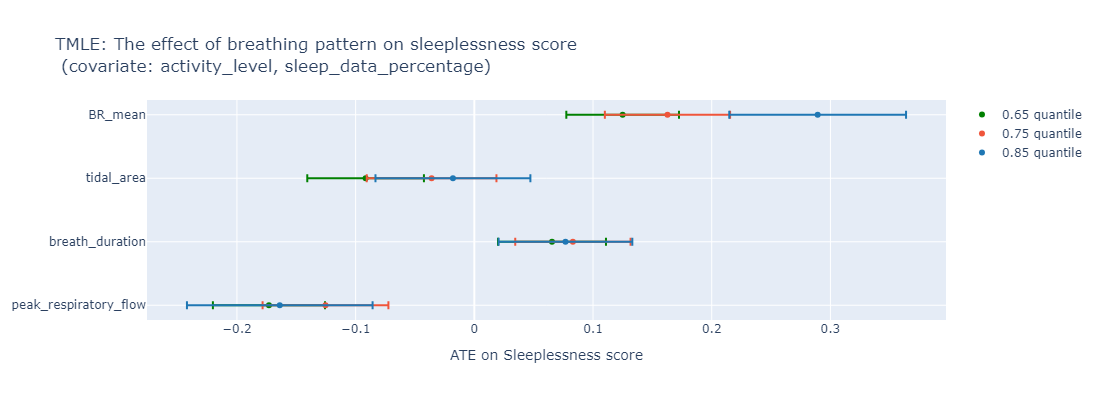

In [32]:
fig = go.Figure()

df = pd.read_csv(f"results/NHS/TMLE/agg/tmle_quantile0.65.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.65 quantile", line_color='green'))
df = pd.read_csv(f"results/NHS/TMLE/agg/tmle_quantile0.75.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.75 quantile"))
df = pd.read_csv(f"results/NHS/TMLE/agg/tmle_quantile0.85.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.85 quantile", line_color='#1f77b4'))

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(
    title=f"TMLE: The effect of breathing pattern on sleeplessness score <br> (covariate: activity_level, sleep_data_percentage)",
    xaxis_title="ATE on Sleeplessness score",
    autosize=False,
    width=800,
    height=400,
)
fig.show()

In [24]:
df = pd.read_csv(f"results/NHS/TMLE/agg/tmle_quantile0.85.csv")
df["p_value"] = norm.sf(abs(df.V2/df.V3))
df

,V1,V2,V3,p_value
0,BR_mean,0.289241,0.074468,0.000051
1,tidal_area,-0.018026,0.065256,0.391182
2,breath_duration,0.076781,0.056322,0.086404
3,peak_respiratory_flow,-0.163914,0.078198,0.018035


In [20]:
id_num = pd.DataFrame(columns=["id", "sleep", "awake", "days"])
scores = pd.read_csv("results/NHS/df_agg.csv")
for f in os.listdir('results/NHS/SleepAwake/'):
    df = pd.read_csv('results/NHS/SleepAwake/' + f)
    id = f[:6]
    if len(scores[scores.id == id]) != 0:
        id_num.loc[len(id_num)] = {"id": id, 
                                   "sleep": len(df[df.isSleep == 1]), 
                                   "awake": len(df[df.isSleep == 0]), 
                                   "days": len(scores[scores.id == id])}
id_num = id_num.set_index("id")
id_num

,sleep,awake,days
id,,,
PRB001,11199,20272,17
PRB003,28890,30546,28
PRB005,20048,43437,38
PRB006,26604,24007,32
PRB007,31599,19745,40
PRB102,20510,58094,23
PRB103,24660,54183,45
PRB104,42391,28470,53
PRB105,50777,48093,63


In [56]:
df = pd.read_csv(f"results/NHS/TMLE/tmle_{v}_quantile{q}.csv")
df = df.rename({"V2": "est", "V3": "se"}, axis=1)
df["p_value"] = norm.sf(abs(df.est/df.se))
df["adjusted_p_value"] = false_discovery_control(df.p_value)
df["rejected"] = np.where(df.adjusted_p_value < 0.05, True, False)
df

,V1,est,se,p_value,adjusted_p_value,rejected
0,PRB001,-0.253567,0.138311,3.337851e-02,7.092932e-02,False
1,PRB003,-0.191642,0.180352,1.439818e-01,2.447690e-01,False
2,PRB005,0.251373,0.056179,3.830095e-06,3.255581e-05,True
3,PRB006,0.789560,0.102551,6.845246e-15,1.163692e-13,True
4,PRB007,0.545340,0.291144,3.052764e-02,7.092932e-02,False
5,PRB102,-0.080503,0.342616,4.071176e-01,4.386942e-01,False
6,PRB103,0.266188,0.086485,1.042453e-03,3.544341e-03,True
7,PRB104,0.037470,0.056909,2.551339e-01,3.614397e-01,False
8,PRB105,0.292657,0.079610,1.184043e-04,6.709576e-04,True
9,PRB107,0.288147,0.097888,1.621868e-03,4.595294e-03,True


In [17]:
features

['BR_mean', 'tidal_area', 'breath_duration', 'peak_respiratory_flow']

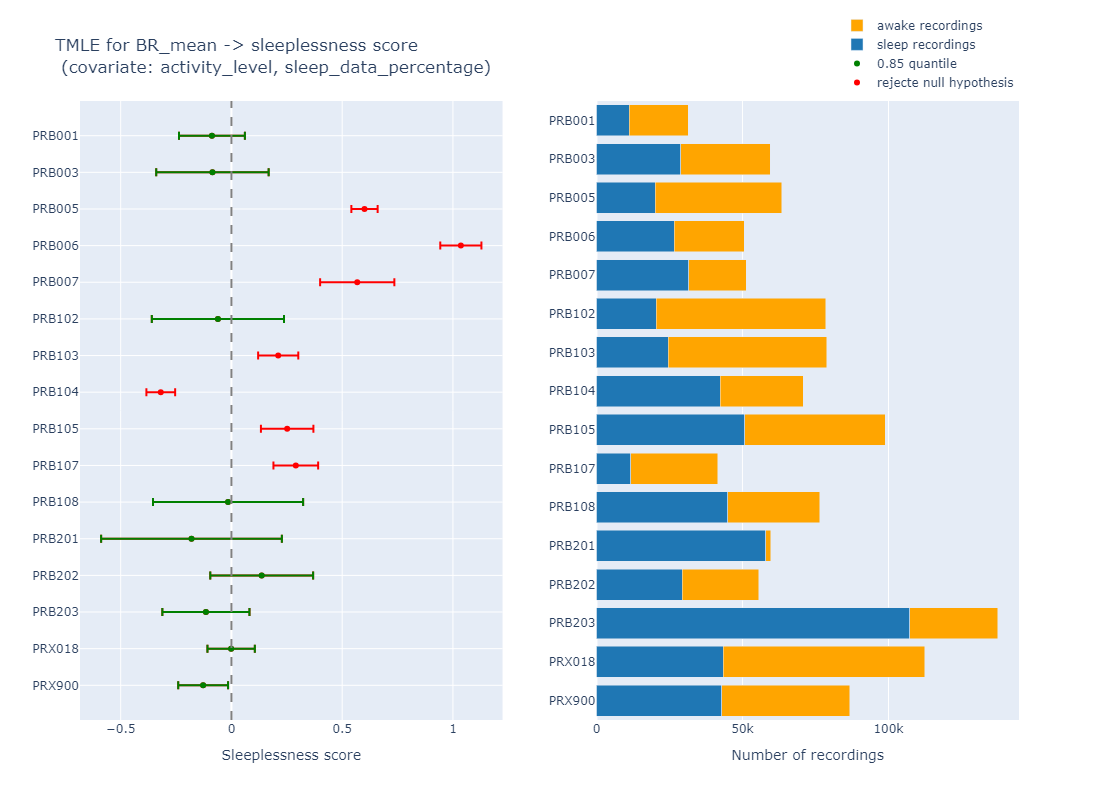

In [77]:
v = 'BR_mean'
fig = make_subplots(rows=1, cols=2)

# df = pd.read_csv(f"results/NHS/TMLE/tmle_{v}_quantile0.65.csv")
# fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.65 quantile", line_color='green'), row=1, col=1)
# df = pd.read_csv(f"results/NHS/TMLE/tmle_{v}_quantile0.75.csv")
# fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.75 quantile"), row=1, col=1)
# df = pd.read_csv(f"results/NHS/TMLE/tmle_{v}_quantile0.85.csv")
# fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.85 quantile", line_color='#1f77b4'), row=1, col=1)

q = 0.85
df = pd.read_csv(f"results/NHS/TMLE/tmle_{v}_quantile{q}.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="rejecte null hypothesis", line_color='red'), row=1, col=1)
df["p_value"] = norm.sf(abs(df.V2/df.V3))
df["adjusted_p_value"] = false_discovery_control(df.p_value)
df["rejected"] = np.where(df.adjusted_p_value < 0.1, True, False)
df = df[~df.rejected]

fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name=f"{q} quantile", line_color='green'), row=1, col=1)
fig.add_vline(x=0, line_dash="dash", line_color="grey", row=1, col=1)

fig.add_trace(go.Bar(
    x=id_num.sleep,
    y=id_num.index,
    name='sleep recordings',
    orientation='h',
    marker_color='#1f77b4'),
    row=1, col=2)

fig.add_trace(go.Bar(
    x=id_num.awake,
    y=id_num.index,
    name='awake recordings',
    orientation='h',
    marker_color='orange'),
    row=1, col=2,)

fig.update_yaxes(row=1, col=1, autorange='reversed')
fig.update_yaxes(row=1, col=2, autorange='reversed')
fig.update_layout(barmode='stack')
fig.update_layout(
    title=f"TMLE for {v} -> sleeplessness score <br> (covariate: activity_level, sleep_data_percentage)",
    xaxis1_title="Sleeplessness score",
    xaxis2_title="Number of recordings",
    autosize=False,
    width=1000,
    height=800,
    legend=dict(
        yanchor="bottom",
        y=1.005,
        xanchor="right",
        x=1)
)
fig.show()

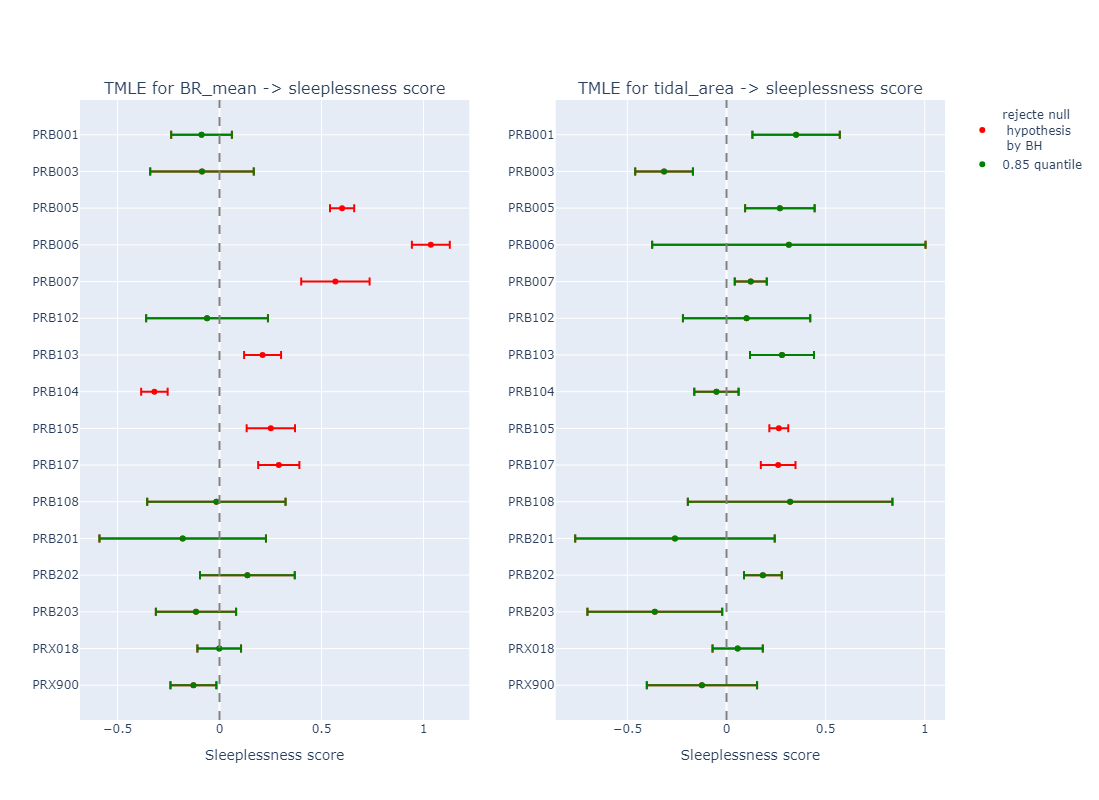

In [43]:
v1 = 'BR_mean'
v2 = 'tidal_area'
fig = make_subplots(rows=1, cols=2, subplot_titles=(f"TMLE for {v1} -> sleeplessness score", f"TMLE for {v2} -> sleeplessness score"))

q = 0.85
df = pd.read_csv(f"results/NHS/TMLE/tmle_{v1}_quantile{q}.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="rejecte null <br> hypothesis <br> by BH", line_color='red'), row=1, col=1)
df["p_value"] = norm.sf(abs(df.V2/df.V3))
df["adjusted_p_value"] = false_discovery_control(df.p_value)
df["rejected"] = np.where(df.adjusted_p_value < 0.05, True, False)
df = df[~df.rejected]

fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name=f"{q} quantile", line_color='green'), row=1, col=1)
fig.add_vline(x=0, line_dash="dash", line_color="grey", row=1, col=1)

df = pd.read_csv(f"results/NHS/TMLE/tmle_{v2}_quantile{q}.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="rejecte null <br> hypothesis <br> by BH", line_color='red', showlegend=False), row=1, col=2)
df["p_value"] = norm.sf(abs(df.V2/df.V3))
df["adjusted_p_value"] = false_discovery_control(df.p_value)
df["rejected"] = np.where(df.adjusted_p_value < 0.05, True, False)
df = df[~df.rejected]

fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name=f"{q} quantile", line_color='green', showlegend=False), row=1, col=2)
fig.add_vline(x=0, line_dash="dash", line_color="grey", row=1, col=2)

fig.update_yaxes(row=1, col=1, autorange='reversed')
fig.update_yaxes(row=1, col=2, autorange='reversed')
fig.update_layout(barmode='stack')
fig.update_layout(
    # title=f"TMLE for {v1} / {v2} -> sleeplessness score <br> (covariate: activity_level, sleep_data_percentage)",
    xaxis1_title="Sleeplessness score",
    xaxis2_title="Sleeplessness score",
    autosize=False,
    width=1000,
    height=800,
    # legend=dict(
    #     yanchor="bottom",
    #     y=1.005,
    #     xanchor="right",
    #     x=1)
)
fig.show()

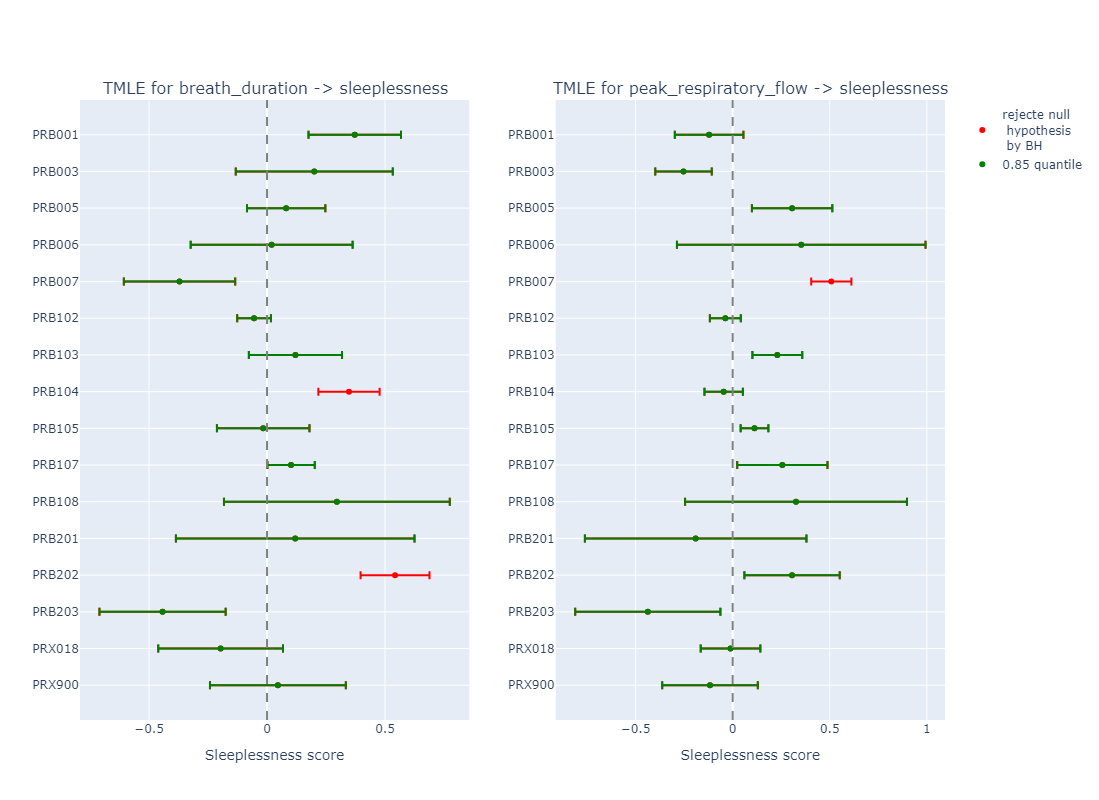

In [44]:
v1 = 'breath_duration'
v2 = 'peak_respiratory_flow'
fig = make_subplots(rows=1, cols=2, subplot_titles=(f"TMLE for {v1} -> sleeplessness", f"TMLE for {v2} -> sleeplessness"))

q = 0.85
df = pd.read_csv(f"results/NHS/TMLE/tmle_{v1}_quantile{q}.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="rejecte null <br> hypothesis <br> by BH", line_color='red'), row=1, col=1)
df["p_value"] = norm.sf(abs(df.V2/df.V3))
df["adjusted_p_value"] = false_discovery_control(df.p_value)
df["rejected"] = np.where(df.adjusted_p_value < 0.05, True, False)
df = df[~df.rejected]

fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name=f"{q} quantile", line_color='green'), row=1, col=1)
fig.add_vline(x=0, line_dash="dash", line_color="grey", row=1, col=1)

df = pd.read_csv(f"results/NHS/TMLE/tmle_{v2}_quantile{q}.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="rejecte null <br> hypothesis <br> by BH", line_color='red', showlegend=False), row=1, col=2)
df["p_value"] = norm.sf(abs(df.V2/df.V3))
df["adjusted_p_value"] = false_discovery_control(df.p_value)
df["rejected"] = np.where(df.adjusted_p_value < 0.05, True, False)
df = df[~df.rejected]

fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name=f"{q} quantile", line_color='green', showlegend=False), row=1, col=2)
fig.add_vline(x=0, line_dash="dash", line_color="grey", row=1, col=2)

fig.update_yaxes(row=1, col=1, autorange='reversed')
fig.update_yaxes(row=1, col=2, autorange='reversed')
fig.update_layout(barmode='stack')
fig.update_layout(
    # title=f"TMLE for {v1} / {v2} -> sleeplessness score <br> (covariate: activity_level, sleep_data_percentage)",
    xaxis1_title="Sleeplessness score",
    xaxis2_title="Sleeplessness score",
    autosize=False,
    width=1000,
    height=800,
    # legend=dict(
    #     yanchor="bottom",
    #     y=1.005,
    #     xanchor="right",
    #     x=1)
)
fig.show()

## TMLE results with CAT

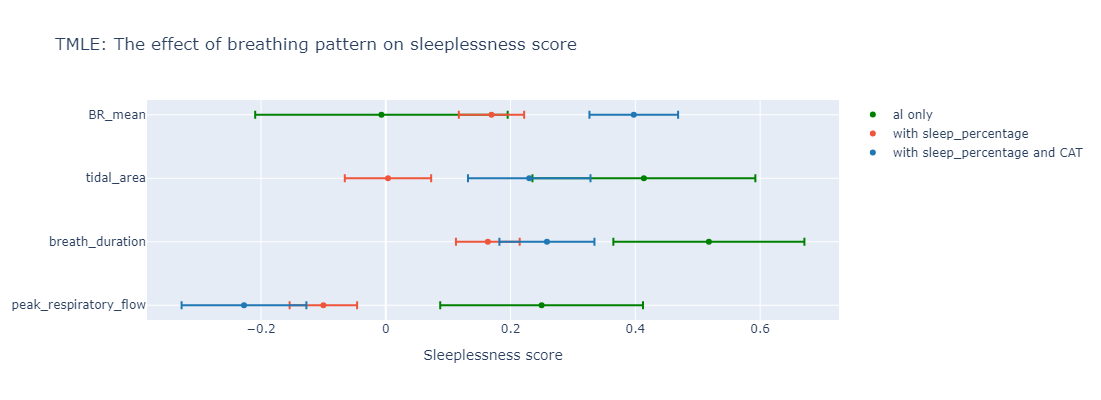

In [142]:
fig = go.Figure()

df = pd.read_csv(f"results/NHS/TMLE/agg/tmle.csv")
df = df[df.V1.isin(['BR_mean','tidal_area','breath_duration','peak_respiratory_flow'])]
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="al only", line_color='green'))
df = pd.read_csv(f"results/NHS/TMLE/agg/tmle_quantile0.75.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="with sleep_percentage"))
df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_quantile0.75.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="with sleep_percentage and CAT", line_color='#1f77b4'))

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(
    title=f"TMLE: The effect of breathing pattern on sleeplessness score",
    xaxis_title="Sleeplessness score",
    autosize=False,
    width=800,
    height=400,
)
fig.show()

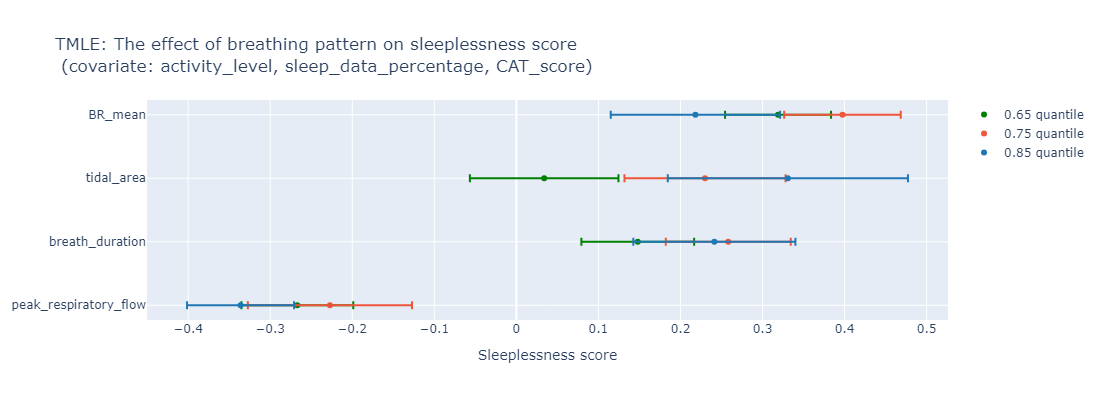

In [149]:
fig = go.Figure()

df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_quantile0.65.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.65 quantile", line_color='green'))
df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_quantile0.75.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.75 quantile"))
df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_quantile0.85.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.85 quantile", line_color='#1f77b4'))

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(
    title=f"TMLE: The effect of breathing pattern on sleeplessness score <br> (covariate: activity_level, sleep_data_percentage, CAT_score)",
    xaxis_title="Sleeplessness score",
    autosize=False,
    width=800,
    height=400,
)
fig.show()

In [122]:
columns

['BR_mean',
 'AL_mean',
 'tidal_area',
 'breath_duration',
 'peak_respiratory_flow']

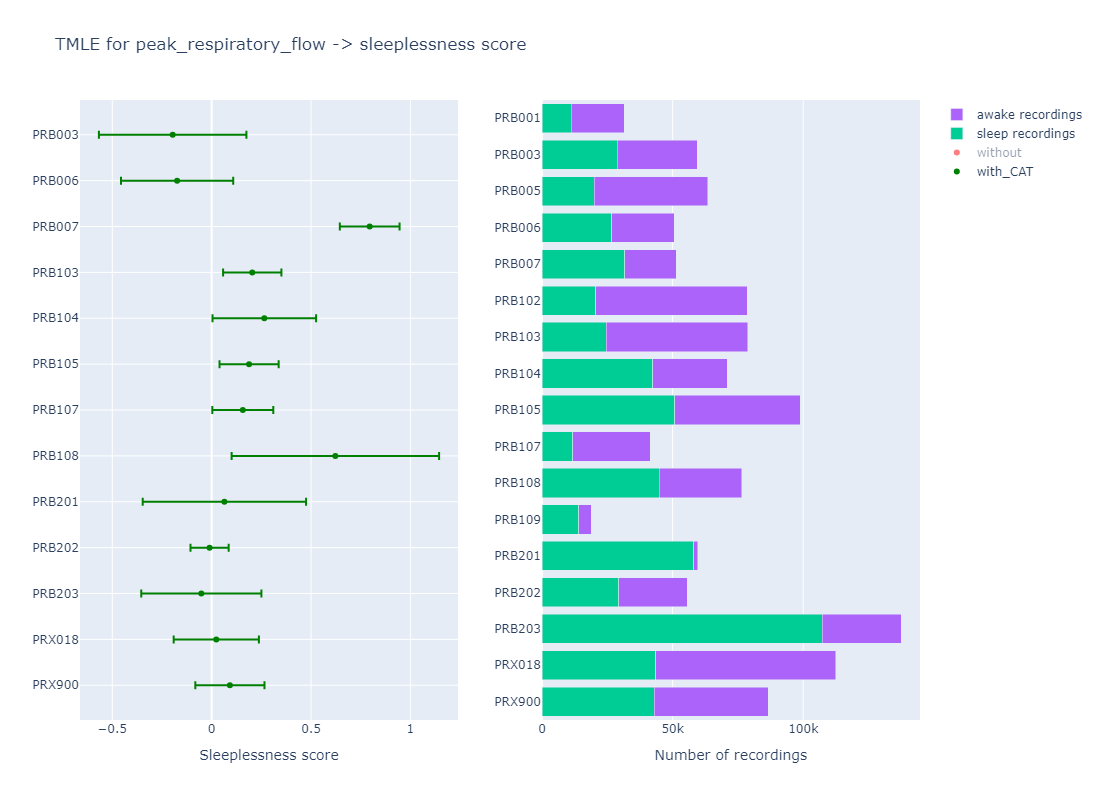

In [128]:
v = 'peak_respiratory_flow'
fig = make_subplots(rows=1, cols=2)

df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_{v}_quantile0.65.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="with_CAT", line_color='green'), row=1, col=1)
df = pd.read_csv(f"results/NHS/TMLE/tmle_{v}_quantile0.65.csv")
fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="without", line_color='red'), row=1, col=1)
# df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_{v}_quantile0.75.csv")
# fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.75 quantile"), row=1, col=1)
# df = pd.read_csv(f"results/NHS/TMLE/with_CAT/tmle_{v}_quantile0.85.csv")
# fig.add_trace(go.Scatter(x=df.V2, y=df.V1, mode='markers', error_x=dict(array=df.V3), name="0.85 quantile", line_color='#1f77b4'), row=1, col=1)

fig.add_trace(go.Bar(
    x=id_num.sleep,
    y=id_num.index,
    name='sleep recordings',
    orientation='h'),
    row=1, col=2)

fig.add_trace(go.Bar(
    x=id_num.awake,
    y=id_num.index,
    name='awake recordings',
    orientation='h'),
    row=1, col=2)

fig.update_yaxes(row=1, col=1, autorange='reversed')
fig.update_yaxes(row=1, col=2, autorange='reversed')
fig.update_layout(barmode='stack')
fig.update_layout(
    title=f"TMLE for {v} -> sleeplessness score",
    xaxis1_title="Sleeplessness score",
    xaxis2_title="Number of recordings",
    autosize=False,
    width=1000,
    height=800,
)
fig.show()

## TMLE results

In [6]:
sa = []
for i in ['BR_mean', 'tidal_area', 'breath_duration', 'peak_respiratory_flow']:
    sa.append(i)
    sa.append(i+"_awake")
    sa.append(i+"_sleep")
sa

['BR_mean',
 'BR_mean_awake',
 'BR_mean_sleep',
 'tidal_area',
 'tidal_area_awake',
 'tidal_area_sleep',
 'breath_duration',
 'breath_duration_awake',
 'breath_duration_sleep',
 'peak_respiratory_flow',
 'peak_respiratory_flow_awake',
 'peak_respiratory_flow_sleep']

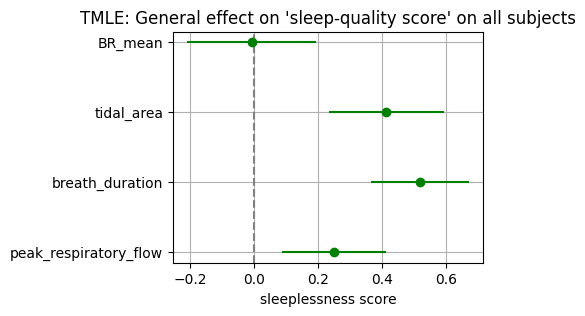

In [152]:
df = pd.read_csv(f"results/NHS/TMLE/agg/tmle.csv") 
df_sorted = pd.DataFrame(index=['BR_mean', 'tidal_area', 'breath_duration', 'peak_respiratory_flow'])
df_sorted = df_sorted.merge(df, left_index=True, right_on="V1")
df_sorted.columns=["variable", "est", "se"]
df = df_sorted

plt.figure(figsize=(4, 3))
plt.errorbar(df['est'], df['variable'], xerr=df['se'], linestyle='None', fmt='o', color='green')
plt.axvline(x=0, linestyle='--', c='grey')
plt.gca().invert_yaxis()
plt.xlabel("sleeplessness score")
plt.title(f"TMLE: General effect on 'sleep-quality score' on all subjects")
plt.grid(True)

In [151]:
pd.read_csv(f"results/NHS/TMLE/agg/tmle.csv")

,V1,V2,V3
0,BR_mean,-0.006968,0.202337
1,tidal_area,0.413700,0.178622
2,breath_duration,0.517842,0.153097
3,peak_respiratory_flow,0.249749,0.162492
4,BR_mean_sleep,-0.507537,0.210689
5,tidal_area_sleep,0.873156,0.161376
6,breath_duration_sleep,0.771786,0.160646
7,peak_respiratory_flow_sleep,0.523114,0.165385
8,BR_mean_awake,-0.919568,0.212174
9,tidal_area_awake,-0.008228,0.197849


In [154]:
df = pd.read_csv(f"results/NHS/TMLE/agg/tmle.csv")
columns = ['BR_mean', 'AL_mean', 'tidal_area', 'breath_duration', 'peak_respiratory_flow']
df_sorted = pd.DataFrame(index=sa)
df_sorted = df_sorted.merge(df, left_index=True, right_on="V1")
df_sorted.columns=["variable", "est", "se"]
df_sorted

,variable,est,se
0,BR_mean,-0.006968,0.202337
8,BR_mean_awake,-0.919568,0.212174
4,BR_mean_sleep,-0.507537,0.210689
1,tidal_area,0.413700,0.178622
9,tidal_area_awake,-0.008228,0.197849
5,tidal_area_sleep,0.873156,0.161376
2,breath_duration,0.517842,0.153097
10,breath_duration_awake,0.594995,0.170057
6,breath_duration_sleep,0.771786,0.160646
3,peak_respiratory_flow,0.249749,0.162492


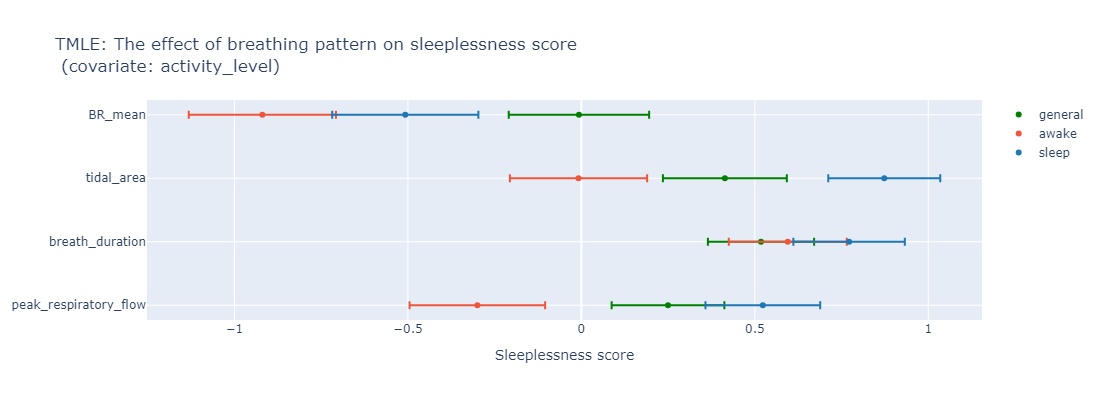

In [155]:
fig = go.Figure()

df1 = df_sorted[df_sorted.variable.isin(columns)]
fig.add_trace(go.Scatter(x=df1.est, y=df1.variable, mode='markers', error_x=dict(array=df1.se), name="general", line_color='green'))
df = df_sorted[df_sorted.variable.isin([i+"_awake" for i in columns])]
fig.add_trace(go.Scatter(x=df.est, y=df1.variable, mode='markers', error_x=dict(array=df.se), name="awake"))
df = df_sorted[df_sorted.variable.isin([i+"_sleep" for i in columns])]
fig.add_trace(go.Scatter(x=df.est, y=df1.variable, mode='markers', error_x=dict(array=df.se), name="sleep", line_color='#1f77b4'))

fig['layout']['yaxis']['autorange'] = "reversed"
fig.update_layout(
    title=f"TMLE: The effect of breathing pattern on sleeplessness score <br> (covariate: activity_level)",
    xaxis_title="Sleeplessness score",
    autosize=False,
    width=800,
    height=400,
)
fig.show()

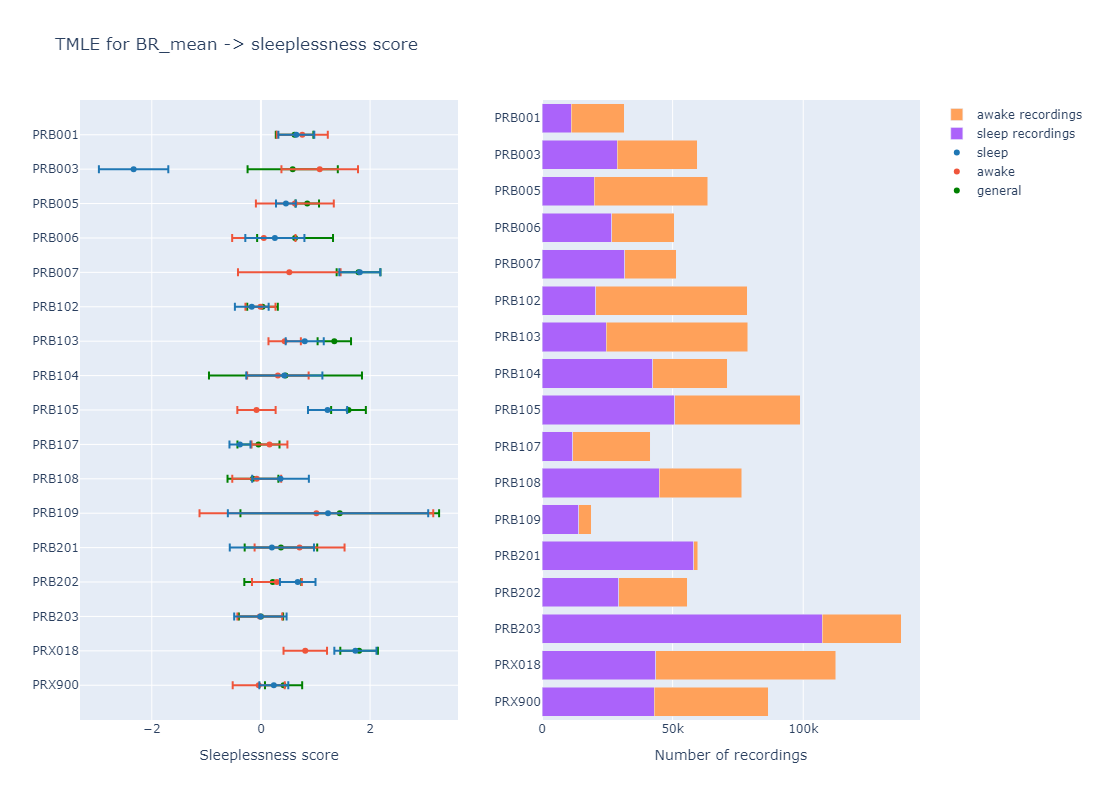

In [90]:
v = 'BR_mean'
fig = make_subplots(rows=1, cols=2)

df1 = pd.read_csv(f"results/NHS/TMLE/old/tmle_{v}.csv")
df1.columns=["id", "est", "se"]
df1 = df1.set_index("id")
fig.add_trace(go.Scatter(x=df1.est, y=df1.index, mode='markers', error_x=dict(array=df1.se), name="general", line_color='green'), row=1, col=1)
df = pd.read_csv(f"results/NHS/TMLE/old/tmle_{v}_awake.csv")
df.columns=["id", "est", "se"]
df = df.set_index("id")
fig.add_trace(go.Scatter(x=df.est, y=df1.index, mode='markers', error_x=dict(array=df.se), name="awake"), row=1, col=1)
df = pd.read_csv(f"results/NHS/TMLE/old/tmle_{v}_sleep.csv")
df.columns=["id", "est", "se"]
df = df.set_index("id")
fig.add_trace(go.Scatter(x=df.est, y=df1.index, mode='markers', error_x=dict(array=df.se), name="sleep", line_color='#1f77b4'), row=1, col=1)

fig.add_trace(go.Bar(
    x=id_num.sleep,
    y=id_num.index,
    name='sleep recordings',
    orientation='h'),
    row=1, col=2)

fig.add_trace(go.Bar(
    x=id_num.awake,
    y=id_num.index,
    name='awake recordings',
    orientation='h'),
    row=1, col=2)

fig.update_yaxes(row=1, col=1, autorange='reversed')
fig.update_yaxes(row=1, col=2, autorange='reversed')
fig.update_layout(barmode='stack')
fig.update_layout(
    title=f"TMLE for {v} -> sleeplessness score",
    xaxis1_title="Sleeplessness score",
    xaxis2_title="Number of recordings",
    autosize=False,
    width=1000,
    height=800,
)
fig.show()

In [274]:
def plot_id(id):
    # id = "PRB003"
    df_id = df_merged[df_merged.id == id]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    fig.add_trace(go.Bar(x=df_id.date, y=df_id.score, name="Sleep-quality score"))
    fig.add_trace(go.Bar(x=df_id.date, y=df_id.CAT_7, name="CAT-sleeplessness"))
    
    for i in columns[2:]:
        fig.add_trace(go.Scatter(x=df_id.date, y=df_id[i], name=i, yaxis="y2", mode='lines+markers'))
    fig.add_trace(go.Scatter(x=df_id.date, y=df_id.BR_mean, name="mean_breathing_rate", yaxis="y3", mode='lines+markers'))
    
    fig.update_layout(
        title=f'Inner comparison for {id}',
        yaxis2_title="mean breathing rate",
        autosize=False,
        width=1100,
        height=400,
        yaxis1=dict(title="scores"),
        yaxis2=dict(title="",
            overlaying="y",
            side="right",
            range=[0,5]),
        yaxis3=dict(title="mean breathing rate",
            anchor="free",
            overlaying="y",
            side="right",
            position=0.98,
            range=[15,28]))
    fig.show()

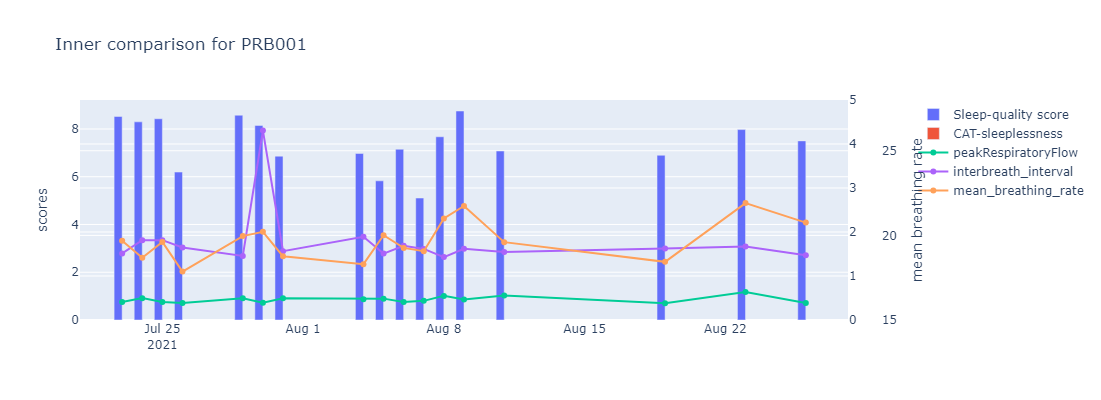

In [275]:
plot_id("PRB001")

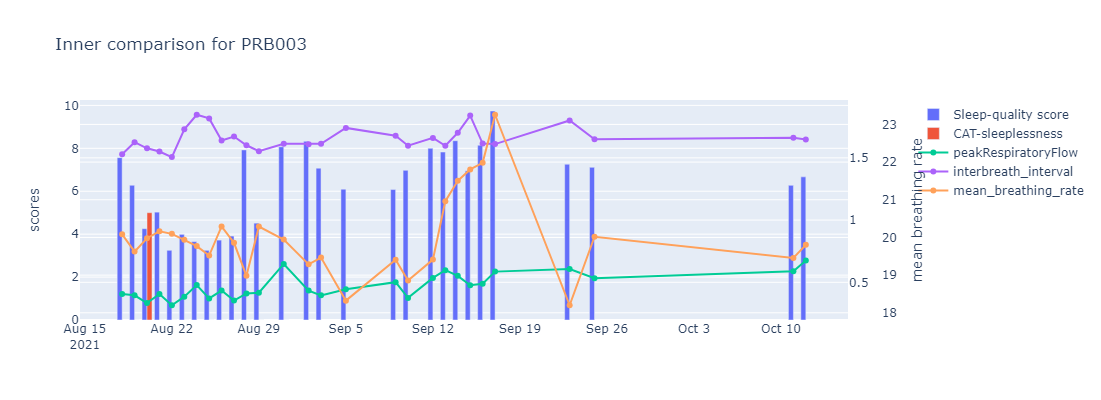

In [276]:
plot_id("PRB00`
")